In [1]:
import proposal as pp
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 14

In [2]:
args = {
    "parametrization": pp.parametrization.pairproduction.KelnerKokoulinPetrukhin(),
    "particle_def": pp.particle.MuMinusDef(),
    "target": pp.medium.Ice(),
    "interpolate": False
}

# Continuous Losses
All energy losses below the energy cut, defined by the `EnergyCutSettings`, are treated as continuous losses. 

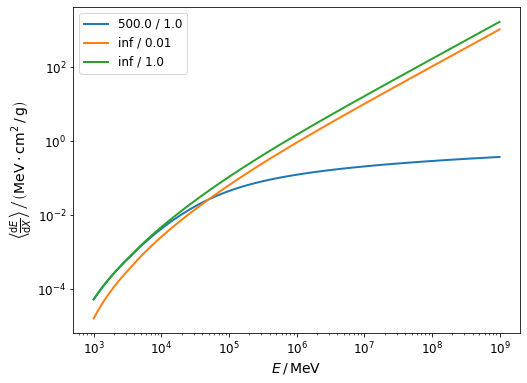

In [3]:
energies = np.geomspace(1e3, 1e9, 100)
cuts = [
    pp.EnergyCutSettings(500, 1, False), 
    pp.EnergyCutSettings(np.Infinity, 0.01, False),
    pp.EnergyCutSettings(np.Infinity, 1, False)
]

for cut in cuts:
    cross = pp.crosssection.make_crosssection(cuts = cut, **args)
    plt.plot(energies, cross.calculate_dEdx(energies), label=f"{cut.ecut} / {cut.vcut}")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'$E \,/\, \mathrm{MeV} $')
plt.ylabel(r'$\left\langle\frac{\mathrm{d}E}{\mathrm{d}X}\right\rangle \,\left/\, \left( \rm{MeV} \cdot \rm{cm}^2 \,/\, \rm{g} \right) \right. $')
plt.legend()

# Stochastic Losses
All energy losses above the energy cut, defined by the `EnergyCutSettings`, are treated as stochastic losses. 
For `inf / 1.0`, all losses are treated continuously, therefore the total stochastic crosssection is zero.

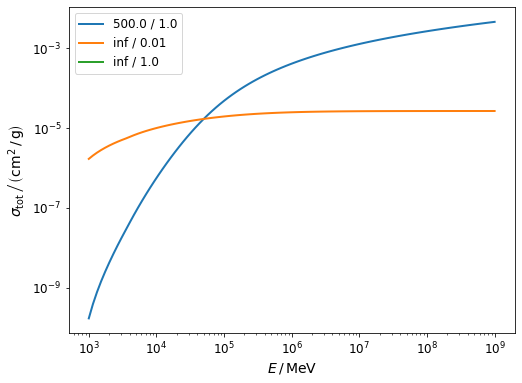

In [4]:
N_SAMPLE = 100
dNdx = np.empty(N_SAMPLE)
energies = np.geomspace(1e3, 1e9, N_SAMPLE)
for cut in cuts:
    cross = pp.crosssection.make_crosssection(cuts = cut,**args)
    for i in range(N_SAMPLE):
        dNdx[i] = cross.calculate_dNdx(energies[i])
    plt.plot(energies, dNdx, label=f"{cut.ecut} / {cut.vcut}")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'$E \,/\, \mathrm{MeV} $')
plt.ylabel(r'$\sigma_\mathrm{tot} \,\left/\, \left( \rm{cm^2} \,/\, \rm{g} \right) \right. $')
plt.legend()

We may also look at the inividual medium components contributing to our stochastic crosssection...

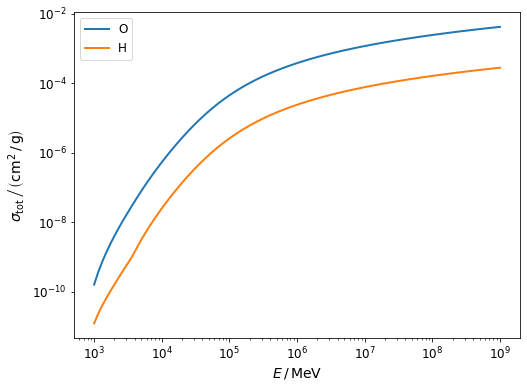

In [5]:
N_SAMPLE = 100
energies = np.geomspace(1e3, 1e9, N_SAMPLE)
cut = pp.EnergyCutSettings(500, 1, False)
cross = pp.crosssection.make_crosssection(cuts = cut,**args)
for t in cross.targets():
    dNdx = np.empty(N_SAMPLE)
    for i in range(N_SAMPLE):
        dNdx[i] = cross.calculate_dNdx(energies[i], t)
    plt.plot(energies, dNdx, label=f"{t.name}")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'$E \,/\, \mathrm{MeV} $')
plt.ylabel(r'$\sigma_\mathrm{tot} \,\left/\, \left( \rm{cm^2} \,/\, \rm{g} \right) \right. $')
plt.legend()

We can sample energy losses by passsing a value between 0 and the full stochastic rate.
From this plot, we can learn that stochastic losses with a small relative energy loss are more likely than losses with high relative energy losses.

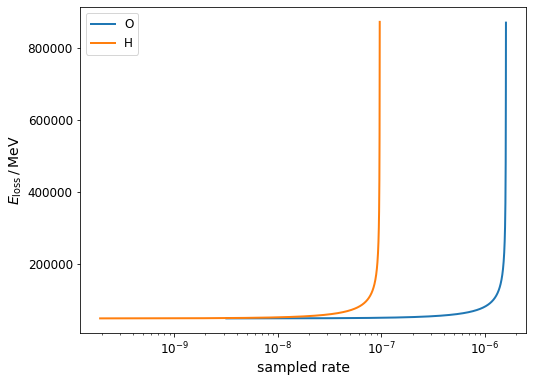

In [6]:
N_SAMPLES = 500
energy = 1e6
cross = pp.crosssection.make_crosssection(cuts = pp.EnergyCutSettings(np.Infinity, 0.05, False),**args)
rates = []
for t in cross.targets():
    rates.append(cross.calculate_dNdx(energy, t))
for t, r in zip(cross.targets(), rates):
    sampled_rate = np.linspace(0, r, N_SAMPLES+1)[1:]
    loss = np.empty(N_SAMPLES)
    for i in range(N_SAMPLES):
        loss[i] = cross.calculate_stochastic_loss(t, energy, sampled_rate[i]) * energy
    plt.plot(sampled_rate, loss, label=f"{t.name}")
plt.xscale("log")
plt.ylabel(r'$E_\mathrm{loss} \,/\, \mathrm{MeV} $')
plt.xlabel(r'sampled rate')
plt.legend()

# Standard CrossSections

PROPOSAL provides optimized standard CrossSections for each particle type.
They are provided by `make_std_crosssection`.

In [7]:
particle_defs = [pp.particle.MuMinusDef(), pp.particle.EPlusDef(), pp.particle.GammaDef()]

args = {
    "target": pp.medium.Ice(),
    "interpolate": False,
    "cuts": pp.EnergyCutSettings(500, 1, False)
}

for p in particle_defs:
    crosssections = pp.crosssection.make_std_crosssection(p, **args)
    print(f"The particle {p.name} has the following interaction types as standard crosssections:")
    for c in crosssections:
        print(f"\t- {c.type.name}")

The particle MuMinus has the following interaction types as standard crosssections:
	- brems
	- epair
	- ioniz
	- photonuclear
The particle EPlus has the following interaction types as standard crosssections:
	- brems
	- epair
	- ioniz
	- photonuclear
	- annihilation
The particle Gamma has the following interaction types as standard crosssections:
	- photopair
	- compton


One may also use a custom set of parametrizations, or append further interactions to the standard crosssection list

In [8]:
p_def = pp.particle.MuMinusDef()
mupair = pp.parametrization.mupairproduction.KelnerKokoulinPetrukhin()

crosssections = pp.crosssection.make_std_crosssection(p_def, **args)
crosssections.append(pp.crosssection.make_crosssection(mupair, p_def, **args))
print(f"The crosssection list includes the following interaction types:")
for c in crosssections:
    print(f"\t- {c.type.name}")

The crosssection list includes the following interaction types:
	- brems
	- epair
	- ioniz
	- photonuclear
	- mupair
